In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
import cv2
import json
import sys
import easyocr
sys.path.append('../src')

%load_ext autoreload
%autoreload 2
from extract_data.scatterplots import clean_data_series, get_lines, get_axes
from extract_data.scatterplots import rescale_points, compare_pred_actual, has_dark_background, detect_graph_space, get_points
from extract_data.scatterplots import get_points_circles, get_xticks, get_yticks

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [3]:
img_df = pd.read_csv('../data/processed/subset_data.csv')
scatter_samples = img_df.query('chart_type == "scatter"')
scatter_samples.head()


chart_type     source  \
14570    scatter  generated   
14571    scatter  generated   
14572    scatter  generated   
14573    scatter  generated   
14574    scatter  generated   

                                             data_series  \
14570  [{'x': 0.9773619580653242, 'y': 78.79986811737...   
14571  [{'x': 1.0341113105924589, 'y': 6.528035647976...   
14572  [{'x': 1990.0441583549366, 'y': 344.8726439123...   
14573  [{'x': 1974.8483623129803, 'y': 17552.88388373...   
14574  [{'x': 1.046979865771812, 'y': 98.658703897990...   

                                            path          name  
14570  ../data/raw/train/images/1738e31c7f3f.jpg  1738e31c7f3f  
14571  ../data/raw/train/images/0f04deb1d36c.jpg  0f04deb1d36c  
14572  ../data/raw/train/images/7609f2a59041.jpg  7609f2a59041  
14573  ../data/raw/train/images/85538063e5a7.jpg  85538063e5a7  
14574  ../data/raw/train/images/4f4603a737bb.jpg  4f4603a737bb

# Updates to the code:

* In the previous notebook I relied entirely on find the axes, and using contours to detect the points.

* The code has been updated to try and detect the entire graph space, or the rectangle where all the points are enclosed. If that space is not found, then the function tries to find the axes as a fallback. 

* The get_axes() function has been updated to trim overlapping lines.

* If get_points() fails as detecting an optimal number of points, I will use a new function called get_points_circles(), which detects circles instead of contours.

* The x and y scale still needs to be inputted manually, as detecting the text from the images remains a challenge.

* The functions get_points() and get_points_circles() require that the number of points be given as an input. This is not ideal, as we would like to automate the process as much as possible. But when dealing with a large number of images with varying quality, the code needs to be given a threshold of contours/circles to find so that the results are optimal.

* Updated rescale_points() to deal with circles detected, not just contour bboxes.

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Mean x-difference:  0.25
Mean y-difference:  1.071


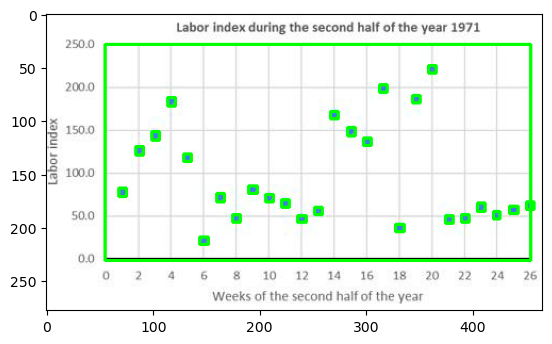

In [6]:
scatter1 = scatter_samples['path'].values[0]
index1 = scatter_samples['data_series'].index[0]

num_points = len(clean_data_series(index1))
points = get_points(scatter1, num_points, show_plot=True)
pred = rescale_points(scatter1, points, 0, 26, 0, 250)
actual = clean_data_series(index1)
x_diff, y_diff = compare_pred_actual(pred, actual, return_diffs=True)

print('Mean x-difference: ',x_diff)
print('Mean y-difference: ',y_diff)

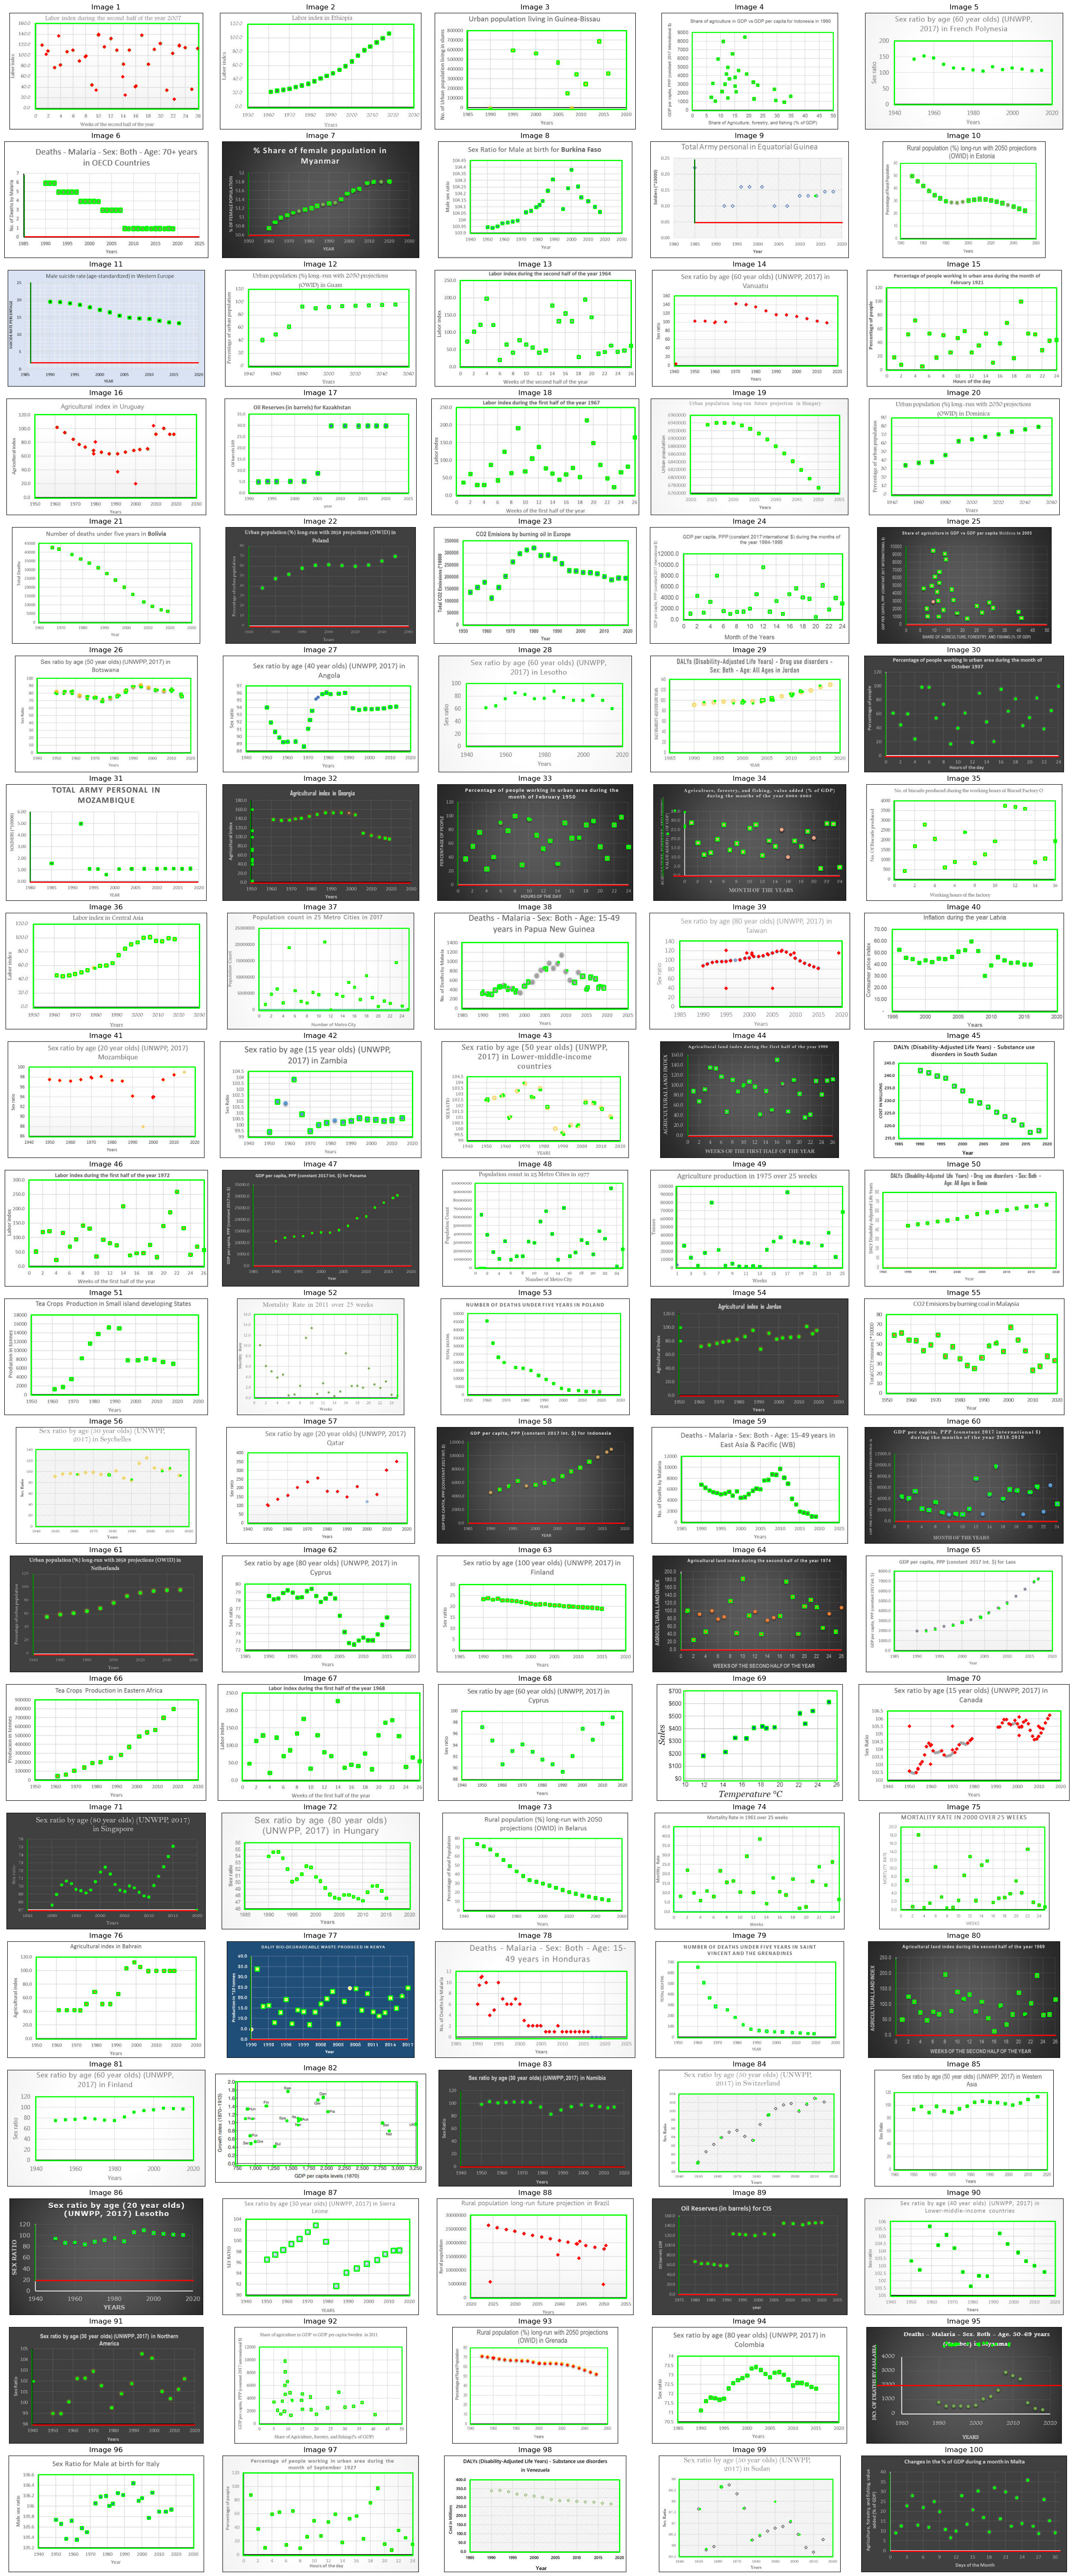

In [7]:
samples_df = img_df.query('chart_type == "scatter"').sample(100, random_state=42)[['path','data_series']]
samples = samples_df['path'].values
indices = list(samples_df.index)

# Number of images per row and column
num_per_row = 5
num_rows = 20

# Calculate the total number of images to display
total_images = num_per_row * num_rows

# Create a new figure with the desired number of subplots
fig, axs = plt.subplots(num_rows, num_per_row, figsize=(25,60), constrained_layout=True)

# Loop through the sample image paths and display the plots
for i, image_path in enumerate(samples[:total_images]):
    
    try:
        # Call your function to detect axes and points
        num_points = len(clean_data_series(indices[i]))
        grid = detect_graph_space(image_path)
        x_axis, y_axis = get_axes(image_path, show_plot=False)
        bounding_boxes = get_points(image_path, num_points=num_points, show_plot=False)
        circles = get_points_circles(image_path, num_points)
        # Load the scatterplot image
        scatter_image = cv2.imread(image_path)

        # Display the image and the detected axes and points in the subplot
        ax = axs[math.floor(i / num_per_row), i % num_per_row]
        
        if grid is not None:
            x, y, w, h = cv2.boundingRect(grid)
            if (x+w)*(y+h) < 90000:
                # Draw the x-axis and y-axis on the scatterplot image
                x1, y1, x2, y2 = x_axis[0]
                ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)

                x1, y1, x2, y2 = y_axis[0]
                ax.plot([x1, x2], [y1, y2], color='green', linewidth=2)
            else:
                cv2.rectangle(scatter_image, (x, y), (x + w, y + h), (0, 255, 0), 2)


            

        else:
            
            # Draw the x-axis and y-axis on the scatterplot image
            x1, y1, x2, y2 = x_axis[0]
            ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            x1, y1, x2, y2 = y_axis[0]
            ax.plot([x1, x2], [y1, y2], color='green', linewidth=2)

    
            
            

        if abs(len(circles) - num_points) < abs(len(bounding_boxes) - num_points):
            for circle in circles:
                cv2.circle(scatter_image, circle, 2, (0, 0, 255), 3)

        elif abs(len(bounding_boxes) - num_points) < abs(len(circles) - num_points):
            for bbox in bounding_boxes:
                x1, y1, x2, y2 = bbox
                cv2.rectangle(scatter_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        ax.imshow(cv2.cvtColor(scatter_image, cv2.COLOR_BGR2RGB))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Image {i+1}')
    except:
        pass
    
# Show the figure with all the subplots
plt.show()

# Evaluate on all scatterplots

In [3]:
df = pd.read_csv('../data/interim/annots_imgs_merged.csv')
df = df[df['chart-type'] == 'scatter']
df = df[['chart-type','data-series','visual-elements.scatter points','file_name', 'image_path']]
df = df.reset_index(drop=True)
df.head()

chart-type                                        data-series  \
0    scatter  [{'x': 1949.4200576738224, 'y': 66.68303958393...   
1    scatter  [{'x': 0.9445463278316278, 'y': 52.13870797394...   
2    scatter  [{'x': 0.8933632249058832, 'y': 5.440194292653...   
3    scatter  [{'x': 0.9873584566532869, 'y': 30.64333251170...   
4    scatter  [{'x': 1989.854169237731, 'y': 31.103360811667...   

                      visual-elements.scatter points     file_name  \
0  [[{'x': 89.33333333333334, 'y': 75.59999999999...  e91e28111e86   
1  [[{'x': 68.76190476190474, 'y': 188.2023809523...  66dd2a250237   
2  [[{'x': 93.33333333333333, 'y': 210.9666666666...  497a547454d7   
3  [[{'x': 67.83333333333334, 'y': 167.15}, {'x':...  07fb50377c3c   
4  [[{'x': 105.83333333333334, 'y': 212.799999999...  daa43320159b   

                                  image_path  
0  ../data/raw/train/images/e91e28111e86.jpg  
1  ../data/raw/train/images/66dd2a250237.jpg  
2  ../data/raw/train/images/497a547454d7.jpg  
3  ../data/raw/train/images/07fb50377c3c.jpg  
4  ../data/raw/train/images/daa43320159b.jpg

In [4]:
x_diffs = []
y_diffs = []
for i in range(len(df)):
        coords = df.iloc[i][2]
        fixed_coords = coords.replace("'","\"")
        data_list = json.loads(fixed_coords)
        x_coords = []
        y_coords = []
        for data_point in data_list[0]:
                x_coords.append(data_point['x'])
                y_coords.append(data_point['y'])
        actual_df = pd.DataFrame({'x_actual':x_coords,'y_actual':y_coords})
        

        img_path = df['image_path'].values[i]
        num_points = len(x_coords)
        
        try:
                points = get_points(img_path, num_points)
                circles = get_points_circles(img_path,num_points)
                x_preds = []
                y_preds = []
                if abs((num_points - len(points))) <= abs((num_points - len(circles))):
                        for point in points:
                                x1, y1, x2, y2 = point
                                x = (x2+x1)/2
                                y = (y2+y1)/2
                                x_preds.append(x)
                                y_preds.append(y)
                               

                else:
                        for point in circles:
                                x, y, r = point
                                x_preds.append(x)
                                y_preds.append(y)

                pred_df = pd.DataFrame({'x_pred':x_preds,'y_pred':y_preds})
                pred_df = pred_df.sort_values(by='x_pred', ascending=True).reset_index(drop=True)
                mean_x_diff = round(abs(pred_df['x_pred'] - actual_df['x_actual']).mean(),3)
                mean_y_diff = round(abs(pred_df['y_pred'] - actual_df['y_actual']).mean(),3)
                x_diffs.append(mean_x_diff)
                y_diffs.append(mean_y_diff)
       
        except:
                x_diffs.append(np.NaN)
                y_diffs.append(np.NaN)
                pass  

        

      

In [9]:
diffs = pd.DataFrame({'x_diffs':x_diffs,'y_diffs':y_diffs})
diffs

x_diffs  y_diffs
0        0.643    0.583
1        0.918    0.473
2       17.022   35.228
3        9.569   14.756
4          NaN      NaN
...        ...      ...
11238   22.232   49.970
11239   24.773   19.507
11240    0.781    0.562
11241    1.373    1.436
11242   20.740   59.965

[11243 rows x 2 columns]

In [16]:
print('Percentage of Scatterplots with missing differences:',round(diffs.isna().sum()[0]/len(diffs),4))

Percentage of Scatterplots with missing differences: 0.1599


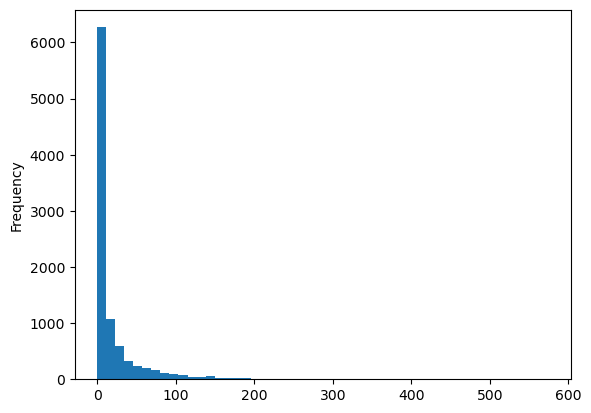

In [22]:
diffs['x_diffs'].plot(kind='hist', bins=50)
plt.show()

In [34]:
print('Percentage of Scatterplots with Accurate Predictions:',round(len(diffs.query('x_diffs < 1'))/len(diffs),4)*100,'%')

Percentage of Scatterplots with Accurate Predictions: 40.94 %


In [37]:
len(diffs.query('x_diffs > 1'))/len(diffs)

0.4291559192386374

# Results:

* The algorithm was not able to extract data from 15.99% of the images.

* Accurate data points were extracted from 40.94% of the images (accurate being defined as images with a less than 1 unit different between the actual data point and the predicted data point).

* Innaccurate data points were extracted from 42.91% of the images.

